# Title: Who's the WinnR ?

## Introduction:
Tennis is not a team sport - thus, tracking *individual* player statistics is critical in understanding what makes a player win or lose a match. During a match, each rally begins with a player serving the ball, and the other player attempting to return it. The players alternate serving and returning.  
A player who is serving the ball is at a significant advantage: they get two attempts to place the ball on court. Thus, you will often see the terms "first serve" and "second serve" when looking through tennis scores. An "ace" is a serve that is unreturned by the other player; in this case, the serving player wins the point. A "double fault" occurs when both the first and second serve are placed out of bounds; this results in the non-serving player winning the point. Naturally, a player hopes to have lots of aces, and very few double faults.   
In our dataset, we have player statistics for each match played in the year 2017. Each row of data represents a match, and contains player statistics for both the winner and the loser of the match. Using our dataset, we will attempt to train a model that predicts whether a player will win or lose that match, based on the number of aces and double faults they commit within a single match.


## Preliminary data analysis:

In [18]:
## load libraries
library(tidyverse)
library(caret)

## read tennis data
game_data <- read_csv("atp2017-2019.csv")

## display table and row number
head(game_data)
nrow(game_data)

## de-select unused columns
game_data <- select(game_data, -tourney_id, -draw_size, -tourney_name, 
                        -match_num, -winner_seed, -winner_entry, -tourney_date, 
                        -loser_seed, -loser_entry, -winner_age, -winner_ioc, -loser_age, 
                    -loser_ioc, -winner_name, -loser_name, -best_of)

## normalize ace/double fault counts by dividing by total service games
game_data <- game_data %>% filter(w_SvGms > 0, l_SvGms >0) %>%
                            mutate(w_ace_per_game = w_ace/w_SvGms, 
                                   l_ace_per_game = l_ace/l_SvGms, 
                                   w_df_per_game  = w_df/w_SvGms, 
                                   l_df_per_game = l_df/l_SvGms)
                            

## set rows from partition
set_rows <- game_data %>%
    select(X1) %>%
    unlist() %>%
    createDataPartition(p = 0.75, list = FALSE)

## divide into training set and testing set
training_set <- game_data %>% slice(set_rows)
testing_set <- game_data %>% slice(-set_rows)


Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)
See spec(...) for full column specifications.


X1,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,⋯,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,⋯,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,⋯,27,15,6,8,1,5,9,3590,40,1050
3,2019-M020,Brisbane,Hard,32,A,20181231,297,104542,NA,⋯,60,38,9,11,4,6,239,200,31,1298
4,2019-M020,Brisbane,Hard,32,A,20181231,296,106421,4,⋯,56,46,19,15,2,4,16,1977,18,1855
5,2019-M020,Brisbane,Hard,32,A,20181231,295,104871,NA,⋯,54,40,18,15,6,9,40,1050,185,275


[1] 6866

In [25]:
## table of ace statistics by court surface
ace_by_surface <- training_set %>%
            group_by(surface) %>%
            summarize(winner_avg_ace_per_game = mean(w_ace_per_game, na.rm = TRUE), 
                      loser_avg_ace_per_game = mean(l_ace_per_game, na.rm = TRUE))
head(ace_by_surface)

## table of double fault statistics by court surface
df_by_surface <- training_set %>%
            group_by(surface) %>%
            summarize(winner_avg_df_per_game = mean(w_df_per_game, na.rm = TRUE), 
                      loser_avg_df_per_game = mean(l_df_per_game, na.rm = TRUE))

head(df_by_surface)

## difference between ace and double fault
differentials <- training_set %>%
        group_by(surface) %>%
        summarize (winner = mean(w_ace - w_df),
                  loser = mean(l_ace - l_df))
head(differentials)

surface,winner_avg_ace_per_game,loser_avg_ace_per_game
<chr>,<dbl>,<dbl>
Clay,0.4114396,0.3054630
Grass,0.7012064,0.5169208
Hard,0.6492995,0.4831111
None,0.4863602,0.2979755


surface,winner_avg_df_per_game,loser_avg_df_per_game
<chr>,<dbl>,<dbl>
Clay,0.1990115,0.2588507
Grass,0.2155157,0.2907244
Hard,0.2187244,0.2856585
None,0.2261831,0.2147592


surface,winner,loser
<chr>,<dbl>,<dbl>
Clay,2.666031,0.8409669
Grass,6.929054,3.6064189
Hard,5.352355,2.7658989
None,4.692308,1.3846154


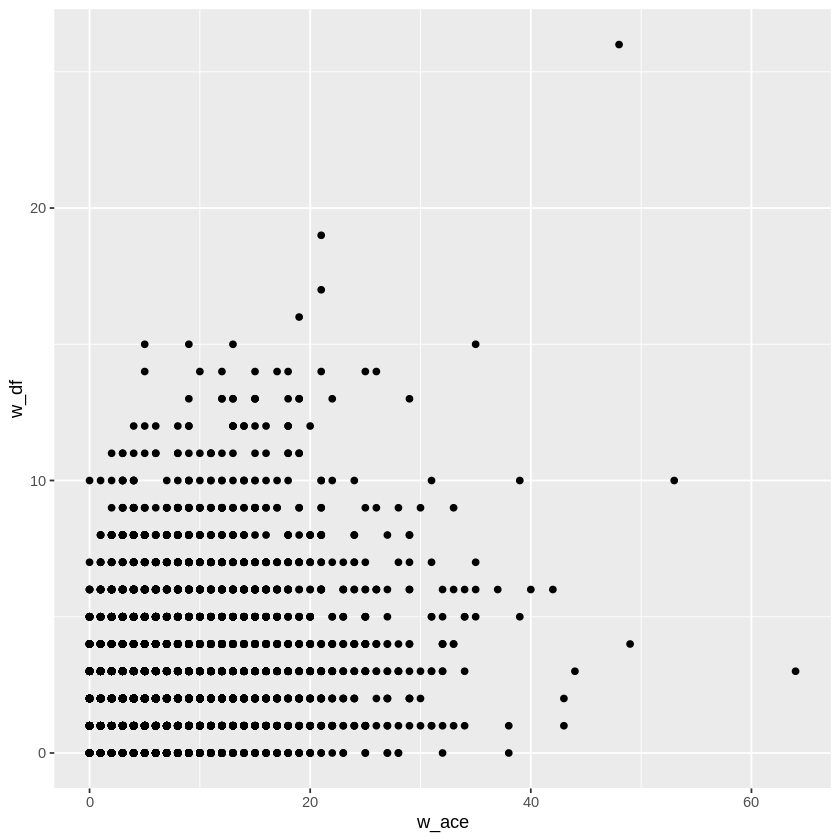

In [23]:
plot <- game_data %>% ggplot(aes(x = w_ace, y = w_df)) + geom_point()
plot